<h1 align=center><font color=red>Battle of Neighborhoods </font><h1>

<h1> <font color=blue>1. Description of the Problem and Discussion of the Background <h1>

## Introduction Section

This final project explores the best locations for Indian restaurants throughout the Queens of New York. New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. New York City is the largest city in the United States with long history of international immigration. They came from many parts of the world. According to 2007 American Community Survey estimates, New York City is home to approximately 315,000 people from the Indian subcontinent.   
With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

## Target Audience

* Business personnel who wants to invest or open a restaurant.
* Freelancer who loves to have their own restaurant as a side business.
* Finding the best location for opening a restaurant.
* Budding Data Scientists, who wants to implement some of the most used Exploratory Data Analysis techniques to
obtain necessary data, analyze it and, finally be able to tell a story out of it. 

<h1> <font color=blue> 2. Data Section <h1>

For this project we need the following data:
1. New York City data that contains Borough, Neighborhoods along with there latitudes and longitudes
    * Data Source: https://cocl.us/new_york_dataset
    * Description : This data set contains the required information. And we will use this data set to explore        various neighborhoods of new york city. 
 
2. Indian resturants in Queens neighborhood of new york city.
    * Data Source: Foursquare API
    * Description : By using this API we will get all the venues in Queens neighborhood. We can filter these venues to get only indian resturants. 

## Approach

* Collect the new york city data from https://cocl.us/new_york_dataset
* Using Foursquare API we will get all venues for each neighborhood.
* Filter out all venues which are Indian Restaurants.
* Data Visualization and some statistical analysis.
* Analysing using Clustering (Specially K-Means):
    1. Find the best value of K 
    2. Visualize the neighborhood with number of Indian Restaurants.
* Compare the Neighborhoods to Find the Best Place for Starting up a Restaurant
* Inference From these Results and related Conclusions

## Problem Statement

1. What are the best location for Indian restaurant in Queens, New York City.
2. In what Neighborhood should I open an Indian restaurant to have the best chance ofd being successful?

## Import all requireda libraries.

In [134]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if this library is not installed.
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<h1> <font color=blue>3. Exploratory Data Analysis <h1>

### We will get Newyork data such as Borough, Neighorhood along with latitude and longitude.

In [135]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
ny_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork = pd.DataFrame(columns=column_names)

### let's loop through the data and fill the dataframe one row at a time.

In [3]:
# Get the Newyork data
for data in ny_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork = newyork.append({'Borough': borough,
                                'Neighborhood': neighborhood_name,
                                'Latitude': neighborhood_lat,
                                'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
# Print Newyork data
print(newyork.shape)
newyork.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


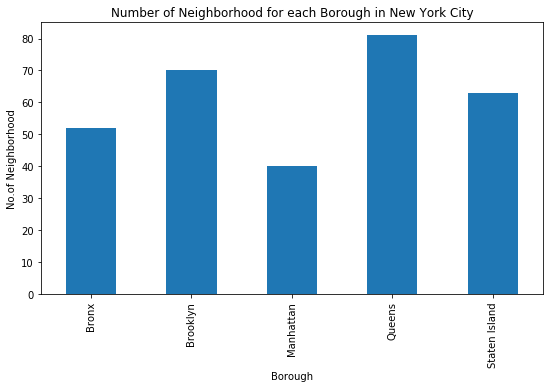

In [5]:
plt.figure(figsize=(9,5))
newyork.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize=10)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=10)
# Display the plot
plt.show()

#### Here we see that Queens has highest number of Neighborhood in Newyork city.

### Define Foursquare Credentials and Version

In [1]:
CLIENT_ID = 'Your-Foursquare_ID' # your Foursquare ID
CLIENT_SECRET = 'Your-Foursquare-Secret' # your Foursquare Secret
VERSION = '20190905' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Your-Foursquare_ID
CLIENT_SECRET:Your-Foursquare-Secret


### We will use geocoder for coordinates of Queens

In [7]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.6524927, -73.7914214158161.


### Get data of Queens

In [8]:
queens_data = newyork[newyork['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


###  we define a function for get near by venues of all neighborhoods

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT=100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [13]:
print(queens_venues.shape)
queens_venues.head()

(2123, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym


In [14]:
queens_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,19,19,19,19,19,19
Astoria,100,100,100,100,100,100
Astoria Heights,14,14,14,14,14,14
Auburndale,21,21,21,21,21,21
Bay Terrace,39,39,39,39,39,39
Bayside,72,72,72,72,72,72
Bayswater,3,3,3,3,3,3
Beechhurst,14,14,14,14,14,14
Bellaire,10,10,10,10,10,10


In [68]:
#Number of unique venue categories
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 271 uniques categories.


In [69]:
# check if the results contain "Indian Restaurants"
"Indian Restaurant" in queens_venues['Venue Category'].unique()

True

### We will do hot encoding for getting dummies

In [70]:
# one hot encoding
to_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhood'] = queens_venues['Neighborhood'] 
to_onehot.set_index('Neighborhood', inplace=True)

In [71]:
to_onehot.reset_index(inplace=True)

In [72]:
to_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0

In [73]:
to_onehot.shape

(2123, 271)

###  Let's Visualize aximum number of Indian restaurant

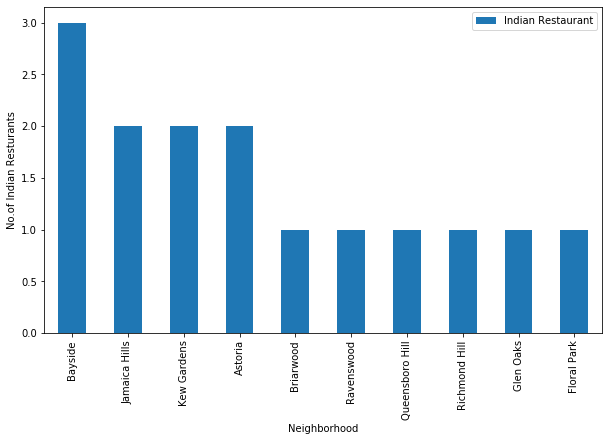

In [130]:
graph = pd.DataFrame(to_onehot.groupby('Neighborhood')['Indian Restaurant'].sum())
graph = graph.sort_values(by='Indian Restaurant', ascending=False)
graph.iloc[:10].plot(kind='bar', figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('No.of Indian Resturants')
plt.show()

### Here we see that *Bayside* has the maximum number of indian restaurants

In [74]:
queens_grouped = to_onehot.groupby('Neighborhood').mean().reset_index()
print(queens_grouped.shape)
queens_grouped.head()

(81, 271)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0

In [75]:
len(queens_grouped[queens_grouped["Indian Restaurant"] > 0])

13

In [98]:
indian_rest = queens_grouped[['Neighborhood','Indian Restaurant']]
print(indian_rest.shape)
indian_rest.head()

(81, 2)


,Neighborhood,Indian Restaurant
0,Arverne,0.00
1,Astoria,0.02
2,Astoria Heights,0.00
3,Auburndale,0.00
4,Bay Terrace,0.00


In [99]:
queens_grouped_clustering = indian_rest.drop('Neighborhood', 1)

## Graph for getting best value of *K* for K-Means

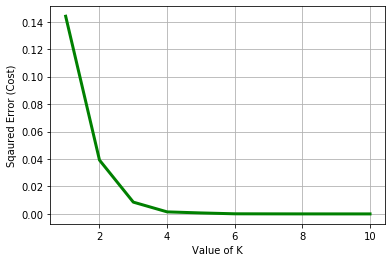

In [101]:
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(queens_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.grid()
plt.show() # clear the plot 

#### According to the graph the best value of K is 3

<h1> <font color=blue>4. Clustering <h1>

In [102]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0], dtype=int32)

In [103]:
# add clustering labels
indian_rest["Cluster Labels"] = kmeans.labels_
indian_rest.head()

/home/vishal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighborhood,Indian Restaurant,Cluster Labels
0,Arverne,0.00,0
1,Astoria,0.02,0
2,Astoria Heights,0.00,0
3,Auburndale,0.00,0
4,Bay Terrace,0.00,0


In [104]:
# merge indian_rest with queens_data to add latitude/longitude for each neighborhood
indian_rest = indian_rest.join(queens_data.set_index("Neighborhood"), on="Neighborhood")
print(indian_rest.shape)
indian_rest.head()

(81, 6)


,Neighborhood,Indian Restaurant,Cluster Labels,Borough,Latitude,Longitude
0,Arverne,0.00,0,Queens,40.589144,-73.791992
1,Astoria,0.02,0,Queens,40.768509,-73.915654
2,Astoria Heights,0.00,0,Queens,40.770317,-73.894680
3,Auburndale,0.00,0,Queens,40.761730,-73.791762
4,Bay Terrace,0.00,0,Queens,40.782843,-73.776802


In [132]:
indian_restaurant = indian_rest[['Neighborhood','Indian Restaurant','Cluster Labels','Latitude','Longitude']]
indian_restaurant.head()

,Neighborhood,Indian Restaurant,Cluster Labels,Latitude,Longitude
0,Arverne,0.00,0,40.589144,-73.791992
1,Astoria,0.02,0,40.768509,-73.915654
2,Astoria Heights,0.00,0,40.770317,-73.894680
3,Auburndale,0.00,0,40.761730,-73.791762
4,Bay Terrace,0.00,0,40.782843,-73.776802


In [106]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(indian_restaurant['Latitude'], indian_restaurant['Longitude'], indian_restaurant['Neighborhood'], indian_restaurant['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [107]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

###  Let's Examine cluster

In [108]:
#Cluster 0
indian_restaurant.loc[indian_restaurant['Cluster Labels'] == 0]

,Neighborhood,Indian Restaurant,Cluster Labels,Latitude,Longitude
0,Arverne,0.000000,0,40.589144,-73.791992
1,Astoria,0.020000,0,40.768509,-73.915654
2,Astoria Heights,0.000000,0,40.770317,-73.894680
3,Auburndale,0.000000,0,40.761730,-73.791762
4,Bay Terrace,0.000000,0,40.782843,-73.776802
6,Bayswater,0.000000,0,40.611322,-73.765968
7,Beechhurst,0.000000,0,40.792781,-73.804365
8,Bellaire,0.000000,0,40.733014,-73.738892
9,Belle Harbor,0.000000,0,40.576156,-73.854018
10,Bellerose,0.000000,0,40.728573,-73.720128


In [109]:
#Cluster 1
indian_restaurant.loc[indian_restaurant['Cluster Labels'] == 1]

,Neighborhood,Indian Restaurant,Cluster Labels,Latitude,Longitude
39,Jamaica Estates,0.333333,1,40.716805,-73.787227


In [110]:
#Cluster 2
indian_restaurant.loc[indian_restaurant['Cluster Labels'] == 2]

,Neighborhood,Indian Restaurant,Cluster Labels,Latitude,Longitude
5,Bayside,0.041667,2,40.766041,-73.774274
13,Briarwood,0.090909,2,40.710935,-73.811748
24,Floral Park,0.125000,2,40.741378,-73.708847
29,Glen Oaks,0.047619,2,40.749441,-73.715481
40,Jamaica Hills,0.090909,2,40.711460,-73.796465
41,Kew Gardens,0.043478,2,40.705179,-73.829819
58,Queensboro Hill,0.040000,2,40.744572,-73.825809
60,Ravenswood,0.041667,2,40.761705,-73.931575
62,Richmond Hill,0.041667,2,40.697947,-73.831833
